# Combined search

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9)]

In this notebook we use nuance to search for periodic transits in combined datasets, that might originate from different instruments or sparse observations. We start by simulating two datasets with different exposures, systematics and noise models, and with a partial overlap.

/Users/lgrcia/code/dev/nuance/nuance/combined.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


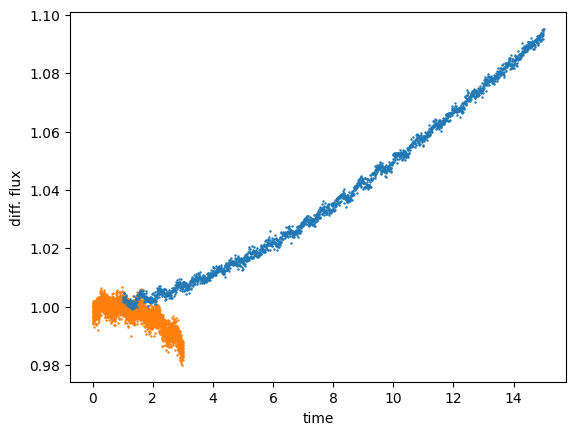

In [2]:
from nuance import Nuance, utils
import matplotlib.pyplot as plt
import numpy as np

true = {"t0": 0.2, "D": 0.05, "P": 0.75, "depth": 8e-4}

# observations with different exposures, systematics and noise models
t = np.linspace(0, 3.0, 3000)
dataset_0, X0, gp0 = utils.simulated(time=t, **true, error=0.002)

t = np.linspace(1.0, 15.0, 2000)
dataset_1, X1, gp1 = utils.simulated(
    time=t, **true, w=[1.0, 10e-4, 5e-4, -0.1e-4], error=0.001
)

plt.plot(dataset_0[0], dataset_0[1], ".", ms=1.5, c="C1")
plt.plot(dataset_1[0], dataset_1[1], ".", ms=1.5, c="C0")
plt.ylabel("diff. flux")
_ = plt.xlabel("time")

We start by performing the linear search on both datasets separately

In [3]:
nu_0 = Nuance(dataset_0[0], dataset_0[1], X=X0, gp=gp0)
nu_1 = Nuance(dataset_1[0], dataset_1[1], X=X1, gp=gp1)

trial_durations = np.linspace(0.01, 0.2, 15)
nu_0.linear_search(dataset_0[0].copy(), trial_durations)
nu_1.linear_search(dataset_1[0].copy(), trial_durations)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

We then combine this dataset to form a single object, that will allow to search for a common transit signal. Note here how each dataset is represented by a different Gaussian Process.

In [4]:
from nuance.combined import CombinedNuance

nus = CombinedNuance([nu_0, nu_1])

The periodic search is then similar to the one performed with a single dataset, and also results in a `SearchResult` object.

In [5]:
periods = np.linspace(0.1, 2.0, 2000)

search = nus.periodic_search(periods)

  0%|          | 0/2000 [00:00<?, ?it/s]

```{note}
The periodic search of the `CombinedNuance` is experimental and not optimized yet
``` 

Before plotting the transit SNR periodogram, let's perform a periodic search on each dataset individually

In [6]:
search0 = nu_0.periodic_search(periods)
search1 = nu_1.periodic_search(periods)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

and finally, plot the results

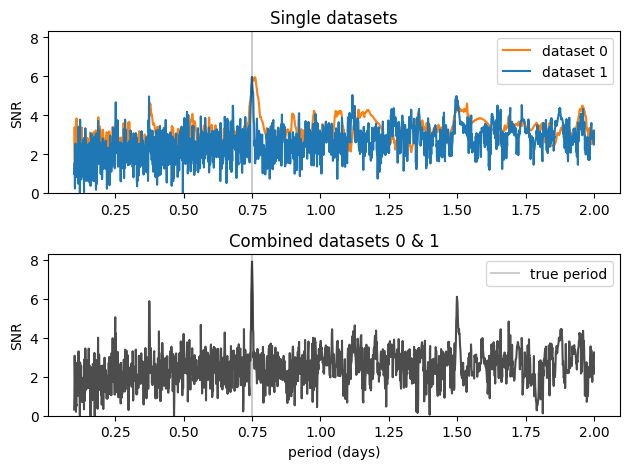

In [7]:
plt.subplot(212)
plt.plot(periods, search.Q_snr, c="0.3")
plt.ylim(
    0,
)
ylim = plt.ylim()
plt.axvline(true["P"], color="k", alpha=0.2, label="true period")
plt.ylabel("SNR")
plt.xlabel("period (days)")
plt.title("Combined datasets 0 & 1")
plt.legend()

plt.subplot(211)
plt.plot(periods, search0.Q_snr, c="C1", label="dataset 0")
plt.plot(periods, search1.Q_snr, c="C0", label="dataset 1")
plt.axvline(true["P"], color="k", alpha=0.2)
plt.ylabel("SNR")
plt.title("Single datasets")
plt.ylim(ylim)
plt.legend()

plt.tight_layout()

As excepted, combining datasets leads to a higher SNR transit detection